### Load data

In [1]:
from sklearn import datasets
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')

diabetes = datasets.load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target)
df = pd.concat([data, target], axis=1)
df.columns.values[-1] = 'target'

### Initialize a TabularMagic object

In [2]:
from tabularmagic.api import TabularMagic
tm = TabularMagic(df, test_size=0.2, name='Diabetes scikit-learn dataset')
tm

INFO: Initialization complete. Shapes of train, test DataFrames: (353, 11), (89, 
      11). 


Diabetes scikit-learn dataset 
--------------------------------------------------------------------------------
Train shape: (353, 11)                   Test shape: (89, 11)                   
--------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                
Continuous variables:
  age, sex, bmi, bp, s1, s2, s3, s4, s5, s6, target 

### Preprocessing

Force sex to binary (0-and-1-valued continuous) variables

In [3]:
tm.datahandler().force_binary(['sex'])

INFO: Forced variables sex to binary. Variables renamed to 
      0.05068011873981862_TRUE(sex). 


Diabetes scikit-learn dataset 
--------------------------------------------------------------------------------
Train shape: (353, 11)                   Test shape: (89, 11)                   
--------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                
Continuous variables:
  age, 0.05068011873981862_TRUE(sex), bmi, bp, s1, s2, s3, s4, s5, s6, target 

### Conduct exploratory analysis

Visualize the distribution of the target variable statified by sex

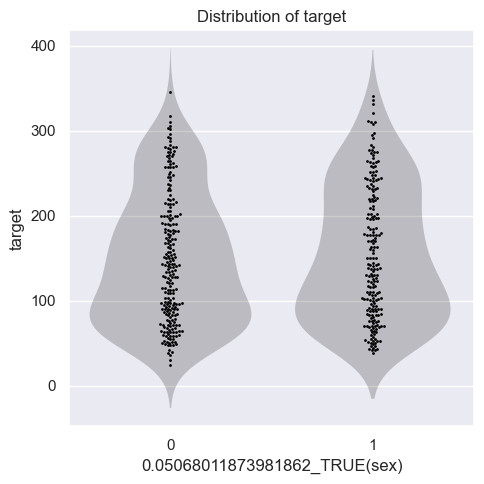

In [4]:
tm.eda(dataset='all').plot_distribution_stratified(
    'target', '0.05068011873981862_TRUE(sex)', strategy='violin_swarm')

Visualize the distribution of the target variable in relation with bmi, age, bp

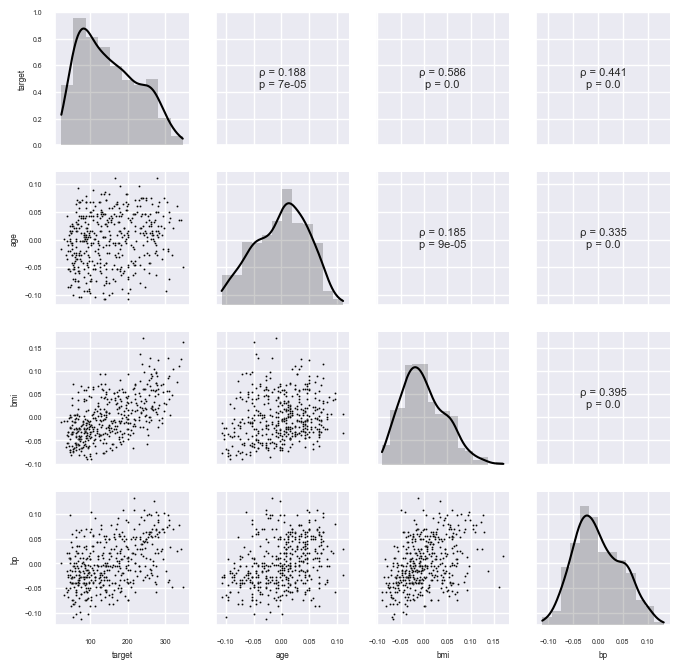

In [5]:
tm.eda(dataset='all').plot_continuous_pairs(
    continuous_vars=['target', 'age', 'bmi', 'bp']
)

### Regression analysis

In [6]:
lm_report = tm.lm(
    formula='target ~ age + bmi + bp + 0.05068011873981862_TRUE(sex) + bp:0.05068011873981862_TRUE(sex)'
)
lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     78.41
Date:                Sat, 01 Jun 2024   Prob (F-statistic):           7.28e-55
Time:                        22:06:40   Log-Likelihood:                -1940.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     347   BIC:                             3915.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              155.3958      4.605     33.746      0.000     146.370     164.421
age                                 66.5596     68.288      0.975      0.330     -67.281     200.401
bmi                                817.1307     75.365     10.842      0.000     669.417     964.844
bp                                 281.0417     95.802      2.934      0.003      93.273     468.810
0.05068011873981862_TRUE(sex)      -10.5060      6.312     -1.664      0.096     -22.878       1.866
bp:0.05068011873981862_TRUE(sex)   293.8286    124.317      2.364      0.018      50.171     537.486
==============================================================================
Omnibus:                        9.655   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                5.330
Skew:                           0.072   Prob(JB):                       0.0696
Kurtosis:                       2.415   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

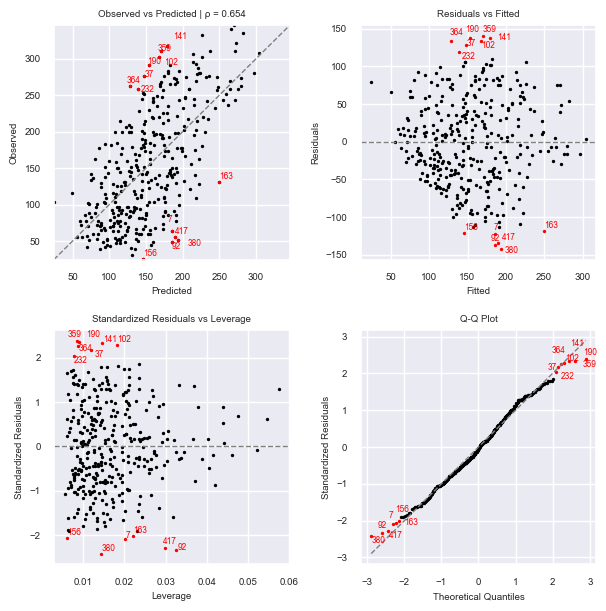

In [7]:
lm_report.train_report().set_outlier_threshold(2).plot_diagnostics(
    show_outliers=True)

In [8]:
lm_report.train_report().fit_statistics()

,OrdinaryLeastSquares_train
Statistic,
rmse,58.954531
mad,48.701527
pearsonr,0.654225
spearmanr,0.623311
r2,0.42801
adjr2,0.419768
n,353


In [9]:
lm_report.test_report().fit_statistics()

,OrdinaryLeastSquares_test
Statistic,
rmse,60.750438
mad,49.979177
pearsonr,0.561894
spearmanr,0.552851
r2,0.303415
adjr2,0.261452
n,89


### Machine learning regression benchmarking

Each model performs a grid search to find optimal estimator. Nested k-fold cross validation is performed to assess model fit on train. Models are also assesed on test.

In [5]:
from tabularmagic.api.mlR import (
    TreeEnsembleR,
    SVMR,
    LinearR,
    MLPR,
)

ml_report = tm.ml_regression(
    models=[
        LinearR('ols'),
        LinearR('l1'),
        LinearR('l2'),
        SVMR('rbf', n_jobs=-1),
        TreeEnsembleR('adaboost', n_jobs=-1),
        MLPR()
    ],
    y_var='age',
    X_vars=['bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    outer_cv=5,
    outer_cv_seed=0
)

INFO: Fitting model LinearR(ols). 
INFO: Fitted model LinearR(ols). 
INFO: Fitting model LinearR(l1). 
INFO: Fitted model LinearR(l1). 
INFO: Fitting model LinearR(l2). 
INFO: Fitted model LinearR(l2). 
INFO: Fitting model SVMR(rbf). 


/Users/andrewyang/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/andrewyang/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


INFO: Fitted model SVMR(rbf). 
INFO: Fitting model TreeEnsembleR(adaboost). 
INFO: Fitted model TreeEnsembleR(adaboost). 
INFO: Fitting model MLPR. 
INFO: Fitted model MLPR. 


In [6]:
ml_report.cv_fit_statistics()

LinearR(ols) LinearR(l1) LinearR(l2) SVMR(rbf)  \
Fold Statistic                                                  
0    rmse          0.045886    0.044788    0.045148    0.0481   
     mad           0.038136    0.037132    0.037436  0.039753   
     pearsonr      0.341267    0.424272    0.388515       NaN   
     spearmanr     0.287469    0.362227    0.335378       NaN   
     r2            0.082463    0.125821    0.111718 -0.008242   
     adjr2        -0.035929    0.013024   -0.002899 -0.138337   
     n                   71          71          71        71   
1    rmse          0.050278    0.050006     0.05001  0.050001   
     mad           0.042486     0.04229    0.042322  0.042126   
     pearsonr      0.236046    0.229672    0.232122  0.172689   
     spearmanr     0.230096    0.223654    0.220634  0.188607   
     r2            0.018574    0.029143    0.029004  0.029343   
     adjr2        -0.108061   -0.096129   -0.096285 -0.095903   
     n                   71          71          71        71   
2    rmse          0.041121    0.040739    0.040523  0.042855   
     mad           0.033523    0.033229    0.033121  0.036033   
     pearsonr      0.355321    0.371313    0.379978   0.25442   
     spearmanr     0.380649    0.392295    0.402514  0.244777   
     r2            0.108309    0.124814    0.134071  0.031504   
     adjr2        -0.006748    0.011887    0.022338 -0.093463   
     n                   71          71          71        71   
3    rmse          0.038341    0.038997    0.039068  0.042402   
     mad           0.031403    0.031825    0.032018  0.033774   
     pearsonr      0.491546    0.485413    0.492429  0.306777   
     spearmanr       0.4806    0.465436    0.471897  0.328425   
     r2             0.18098    0.152684    0.149623 -0.001741   
     adjr2         0.073567     0.04156    0.038099 -0.133117   
     n                   70          70          70        70   
4    rmse          0.040061    0.040501    0.040929  0.043406   
     mad           0.033454    0.033895    0.034224  0.036381   
     pearsonr      0.429762    0.427721    0.398937  0.274111   
     spearmanr     0.419663    0.424549    0.375637  0.264102   
     r2            0.167953    0.149567    0.131491    0.0232   
     adjr2         0.058833    0.038035    0.017588 -0.104905   
     n                   70          70          70        70   

               TreeEnsembleR(adaboost)      MLPR  
Fold Statistic                                    
0    rmse                     0.043329  0.046217  
     mad                      0.035798  0.037605  
     pearsonr                 0.446198  0.414748  
     spearmanr                0.379462  0.346168  
     r2                       0.181864   0.06916  
     adjr2                    0.076298 -0.050948  
     n                              71        71  
1    rmse                     0.047063  0.050135  
     mad                      0.039597  0.042635  
     pearsonr                 0.383183   0.22176  
     spearmanr                0.348272  0.199579  
     r2                       0.140043  0.024144  
     adjr2                    0.029081 -0.101773  
     n                              71        71  
2    rmse                     0.040165  0.040144  
     mad                      0.033255  0.032734  
     pearsonr                 0.392791  0.396707  
     spearmanr                0.328975  0.393805  
     r2                       0.149291  0.150181  
     adjr2                    0.039522  0.040527  
     n                              71        71  
3    rmse                     0.038872  0.038207  
     mad                      0.031307  0.030992  
     pearsonr                 0.512828   0.50135  
     spearmanr                0.485523  0.458678  
     r2                       0.158141  0.186689  
     adjr2                    0.047733  0.080025  
     n                              70        70  
4    rmse                     0.041271  0.041529  
     mad                    

View averaged fit statistics across folds

In [12]:
ml_report.fit_statistics('train')

,LinearR(ols)_train_cv,LinearR(l1)_train_cv,LinearR(l2)_train_cv,SVMR(rbf)_train_cv,TreeEnsembleR(adaboost)_train_cv,MLPR_train_cv
Statistic,,,,,,
rmse,55.922637,56.300856,56.1589,56.638801,60.713838,59.298803
mad,45.70565,46.144134,45.98105,46.373491,48.39716,49.750436
pearsonr,0.704438,0.699251,0.701216,0.700341,0.646174,0.663402
spearmanr,0.679914,0.677564,0.676843,0.670575,0.636187,0.644952
r2,0.475706,0.468273,0.470999,0.462651,0.379449,0.410322
adjr2,0.397786,0.389243,0.392374,0.382802,0.287198,0.322691
n,70.6,70.6,70.6,70.6,70.6,70.6


View fit statistics for each fold

In [13]:
ml_report.cv_fit_statistics()

LinearR(ols)_train_cv LinearR(l1)_train_cv  \
Fold Statistic                                              
0    rmse                  58.010997            58.494235   
     mad                    47.43226            47.935861   
     pearsonr               0.705315             0.697707   
     spearmanr              0.695095             0.688421   
     r2                     0.482068             0.473403   
     adjr2                  0.405652             0.395709   
     n                            71                   71   
1    rmse                  58.221287            58.219826   
     mad                   48.916372            48.915907   
     pearsonr               0.692283             0.692303   
     spearmanr              0.665487             0.665487   
     r2                     0.468511             0.468538   
     adjr2                  0.390095             0.390125   
     n                            71                   71   
2    rmse                  50.304187            50.383579   
     mad                   39.900148            40.061868   
     pearsonr               0.766077             0.768472   
     spearmanr              0.723024             0.735483   
     r2                     0.578251             0.576919   
     adjr2                  0.516026             0.514497   
     n                            71                   71   
3    rmse                  57.482488            58.813103   
     mad                   47.225446            48.753206   
     pearsonr               0.654464             0.633718   
     spearmanr              0.660437             0.642905   
     r2                     0.419045             0.391837   
     adjr2                  0.331901             0.300613   
     n                            70                   70   
4    rmse                  55.594227            55.593537   
     mad                   45.054025            45.053827   
     pearsonr                0.70405             0.704056   
     spearmanr              0.655526             0.655526   
     r2                     0.430656              0.43067   
     adjr2                  0.345254              0.34527   
     n                            70                   70   

               LinearR(l2)_train_cv SVMR(rbf)_train_cv  \
Fold Statistic                                           
0    rmse                 58.305219          60.007916   
     mad                  48.090109          48.959942   
     pearsonr              0.701529           0.698101   
     spearmanr             0.686778           0.685856   
     r2                    0.476801           0.445797   
     adjr2                 0.399608           0.364029   
     n                           71                 71   
1    rmse                 58.091915          58.106913   
     mad                   48.88081          48.867364   
     pearsonr               0.69408           0.703244   
     spearmanr             0.667718           0.665638   
     r2                    0.470871           0.470597   
     adjr2                 0.392802           0.392489   
     n                           71                 71   
2    rmse                 50.329886          51.795526   
     mad                  39.889149          41.461926   
     pearsonr              0.767736           0.769525   
     spearmanr              0.72569           0.729983   
     r2                     0.57782           0.552874   
     adjr2                 0.515531           0.486904   
     n                           71                 71   
3    rmse                 58.474669          60.035554   
     mad                  47.991425          49.286498   
     pearsonr              0.638671           0.616958   
     spearmanr             0.648871           0.619913   
     r2                    0.398816           0.366293   
     adjr2                 0.308639           0.271237   
     n                           70                 70   
4    rmse        

View fit statistics on the withheld testing dataset

In [14]:
ml_report.fit_statistics('test')

,LinearR(ols)_test,LinearR(l1)_test,LinearR(l2)_test,SVMR(rbf)_test,TreeEnsembleR(adaboost)_test,MLPR_test
Statistic,,,,,,
rmse,54.65101,53.863011,54.50193,54.413022,52.919897,56.215125
mad,44.267691,43.826755,44.197353,43.66508,42.586968,46.781418
pearsonr,0.669771,0.675814,0.670675,0.672478,0.687599,0.638443
spearmanr,0.662453,0.664266,0.659848,0.653106,0.639767,0.61857
r2,0.436269,0.452408,0.43934,0.441168,0.471417,0.403539
adjr2,0.372046,0.390024,0.375468,0.377504,0.411198,0.335588
n,89,89,89,89,89,89


View MLPR optimal hyperparameters

In [15]:
ml_report.model('MLPR').hyperparam_searcher().best_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'constant',
 'solver': 'adam'}

Obtain the scikit-learn estimator

In [16]:
ml_report.model('MLPR').sklearn_estimator()

MLPRegressor(hidden_layer_sizes=(100, 50, 25), random_state=42)

View MLPR fit on train data

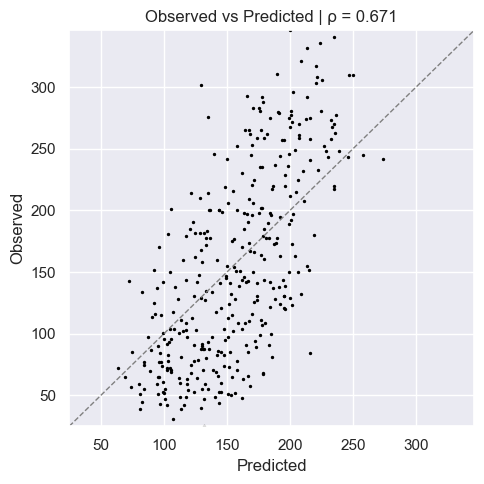

In [17]:
ml_report.model_report('MLPR').train_report().plot_obs_vs_pred()

View MLPR fit on test data

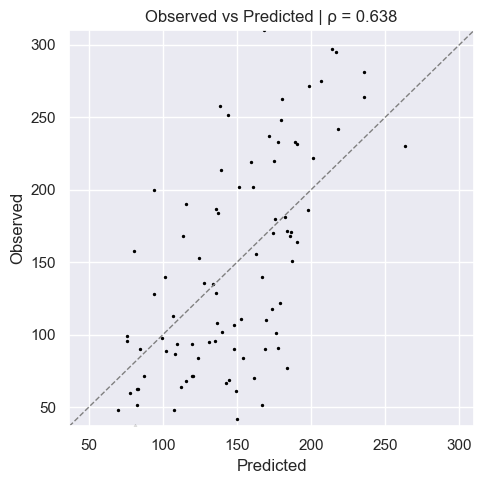

In [18]:
ml_report.model_report('MLPR').test_report().plot_obs_vs_pred()